### Anharmonic Oscillator with RBMs

We want to try creating an emulator using RBMs for the anharmonic oscillator problem from the CAT plot focus Challenge. 

For this problem, we are finding a reduced-basis for the Hamiltonian 
\begin{equation}
    H = -\frac{\partial^2}{\partial x^2} + \kappa_1 x^2 + \kappa_2 x^2,
\end{equation}
as a function of $\kappa_1 \in [0.5,4]$ and $\kappa_2 \in [0,2]$.

To begin, we start with importing the standard requisite packages.

In [114]:
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (16,9)
import time
from scipy.sparse import diags
from scipy.stats import qmc


Next, we define functions that will yield exact solutions (a la code from Josh). From the exact solutions, we will build the RBM emulator using the Galerkin projection. 

In [65]:
def build_mesh(domain,nsteps):
    mesh, dx = np.linspace(domain[0], domain[1], nsteps, retstep=True)
    mesh     = np.resize(mesh, (nsteps,))
    
    return mesh, dx


def exact_solution(params,mesh,dx):
    
    d2_of_x = diags([1, -2, 1], [-1, 0, 1], shape=(mesh.shape[0], mesh.shape[0]))  / ( dx ** 2 )
    H = -d2_of_x + diags( params[0] * mesh ** 2  +  params[1] * mesh ** 4).toarray()

    eigenvalues, eigenvectors = np.linalg.eig(H)
    sort_index                = np.argsort(eigenvalues)
    eigenvalues               = eigenvalues[sort_index]
    eigenvectors              = eigenvectors[:,sort_index].T

    return eigenvalues[0], np.resize(eigenvectors[0], (n,))

With a quick check of the ground state solution for $[\kappa_1, \kappa_2] = [4,2]$.

2.283797632467061


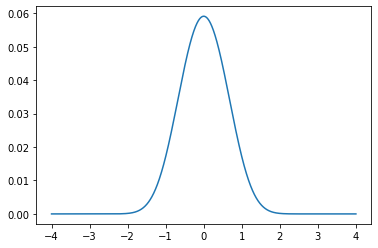

In [109]:
mesh, dx = build_mesh((-4,4),2000)
eigenvalue, eigenvector = exact_solution([4,2],mesh,dx)
print(eigenvalue)
plt.plot(mesh,eigenvector)

For the next part, we draw 10 samples on a Latin Hypercube. Using these samples, we evaluate the exact solution to the anharmonic oscillator. The exact solutions will then be utilized to train the RBM emulator. 

In [110]:
sampler = qmc.LatinHypercube(d=2,seed=193953)
samples = sampler.random(10)
l_bounds = [0.5,0]
u_bounds = [4,2]
sample_scaled = qmc.scale(samples, l_bounds, u_bounds)
exact_samples       = [exact_solution(sample,mesh,dx) for sample in sample_scaled]
eigenvalue_samples  = [exact_samples[i][0] for i in range(len(samples))]
eigenvector_samples = np.array([exact_samples[i][1] for i in range(len(samples))])

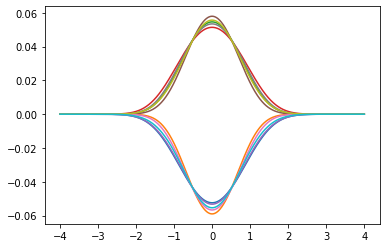

In [111]:
for i in range(len(samples)):
    plt.plot(mesh,eigenvector_samples[i])

In [112]:
U, s ,Vh = np.linalg.svd(eigenvector_samples)

/var/folders/1p/9d8ppj4d6wxdv8qd21krfr280000gn/T/ipykernel_46069/3399818271.py:6: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


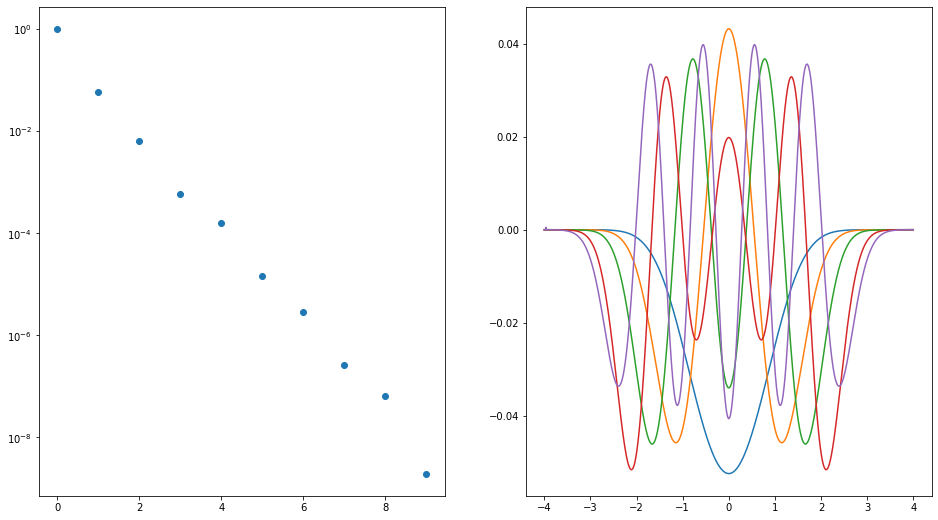

In [121]:
fig, ax = plt.subplots(1,2)
ax[0].scatter(np.arange(s.size),s/s[0])
ax[0].set_yscale('log')
for i in range(5):
    ax[1].plot(mesh,Vh[:,i])
fig.show()